In [226]:
import random
import matplotlib.pyplot as plt
import json
import networkx as nx
from graph_util import GraphUtil

In [227]:
filename = "./data/JavaFX-Point-of-Sales_invocations.json"

In [228]:
with open(filename, "r") as f:
    data = json.loads(f.read())
entities = data['pdg']['entities']
relations = data['pdg']['relations']

entities_dict = {entity['entityId']: entity for entity in entities}

In [229]:
gu = GraphUtil("PYTHON_2")
MG_ORM = gu.build_program_dependency_graph(
                                    entities,
                                    relations,
                                    allowed_entity_types=[],
                                    allowed_relation_types=['ORM'],
                                    entity_attributes=[gu.ENTITY_ID, gu.ENTITY_TYPE, gu.ENTITY_FQN],
                                    directed=True,
                                    isolated_nodes=True,
                                    self_loops=False,
                                    weight="weight",
                                    multi_edges=True)

allowed_types = ['CLASS', 'INTERFACE']

allowed_types_set = set()
for(entity_id) in entities_dict:
    if entities_dict[entity_id]['entityType'] in allowed_types:
        allowed_types_set.add(entity_id)
print('allowed_types_set: ' + repr(allowed_types_set))

allowed_types_set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54}


In [230]:
persistent_set = set()
for (entity_id) in entities_dict:
    if len(MG_ORM.edges(entity_id, data=True)) > 0:
        persistent_set.add(entity_id)
persistent_set.intersection_update(allowed_types_set)
print('persistent_set: ' + repr(persistent_set))
for e in persistent_set:
    print(entities_dict.get(e)['entityFullQualifiedName'])

persistent_set: {2, 3, 4, 6, 7, 8, 9}
com.rafsan.inventory.entity.Product
com.rafsan.inventory.entity.Purchase
com.rafsan.inventory.entity.Invoice
com.rafsan.inventory.entity.Supplier
com.rafsan.inventory.entity.Category
com.rafsan.inventory.entity.Sale
com.rafsan.inventory.entity.Employee


In [231]:
crud_dict:dict = {}
for r in relations:
    if not r['from'] == r['to'] and r['relationType'] == "CRUD":#and (r['from'] in persistent_set and r['to'] in persistent_set):
        print(r['relationType'])
        print(entities_dict.get(r['from'])['entityFullQualifiedName'])
        print(entities_dict.get(r['to'])['entityFullQualifiedName'])
        for inner_r in relations:
            if inner_r['to'] == r['to'] and inner_r['relationType'] == "ORM":
                print(inner_r['relationType'])
                print(entities_dict.get(inner_r['from'])['entityFullQualifiedName'])
                print(entities_dict.get(inner_r['to'])['entityFullQualifiedName'])
                crud_dict[r['from']] = inner_r['from']

print(crud_dict)

CRUD
com.rafsan.inventory.model.ProductModel
products
ORM
com.rafsan.inventory.entity.Product
products
CRUD
com.rafsan.inventory.model.PurchaseModel
purchases
ORM
com.rafsan.inventory.entity.Purchase
purchases
CRUD
com.rafsan.inventory.model.InvoiceModel
invoices
ORM
com.rafsan.inventory.entity.Invoice
invoices
CRUD
com.rafsan.inventory.model.SupplierModel
suppliers
ORM
com.rafsan.inventory.entity.Supplier
suppliers
CRUD
com.rafsan.inventory.model.CategoryModel
categories
ORM
com.rafsan.inventory.entity.Category
categories
CRUD
com.rafsan.inventory.model.SalesModel
sales
ORM
com.rafsan.inventory.entity.Sale
sales
CRUD
com.rafsan.inventory.model.EmployeeModel
employees
ORM
com.rafsan.inventory.entity.Employee
employees
{21: 2, 24: 3, 22: 4, 19: 6, 23: 7, 25: 8, 20: 9}


In [232]:
def visualize_graph(_graph: nx.Graph, fig_size=6, iterate=200):
    # Visualize the graph
    plt.figure(figsize=(fig_size, fig_size))
    shapes = set((aShape[1]["node_shape"] for aShape in _graph.nodes(data = True)))
    colors = set((aColor[1]["color"] for aColor in _graph.nodes(data = True)))
    pos = nx.spring_layout(_graph, seed=42, k=2.4, iterations=iterate)
    for _shape in shapes:
        for _color in colors:
            nx.draw_networkx_nodes(_graph, pos, node_color=_color, node_shape=_shape, node_size=(500+(-100 if _shape == "s" else 0)+(100 if _shape == "p" else 0)),
                                   nodelist=[sNode[0] for sNode in filter(lambda _x: _x[1]["node_shape"]==_shape and _x[1]["color"]==_color,_graph.nodes(data = True))])
    edge_colors = nx.get_edge_attributes(_graph,"color")
    #nx.draw_networkx_edges(_graph, pos, edge_color="grey")
    nx.draw_networkx_edges(_graph, pos, edge_color=edge_colors.values())
    nx.draw_networkx_labels(_graph, pos, font_size=9, font_family="sans-serif", font_color="#ffffff")
    #nx.draw_networkx_edge_labels(
    #    _graph, pos, edge_labels={(u, v): d["weight"] for u, v, d in _graph.edges(data=True)}
    #)
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


MultiDiGraph with 295 nodes and 554 edges


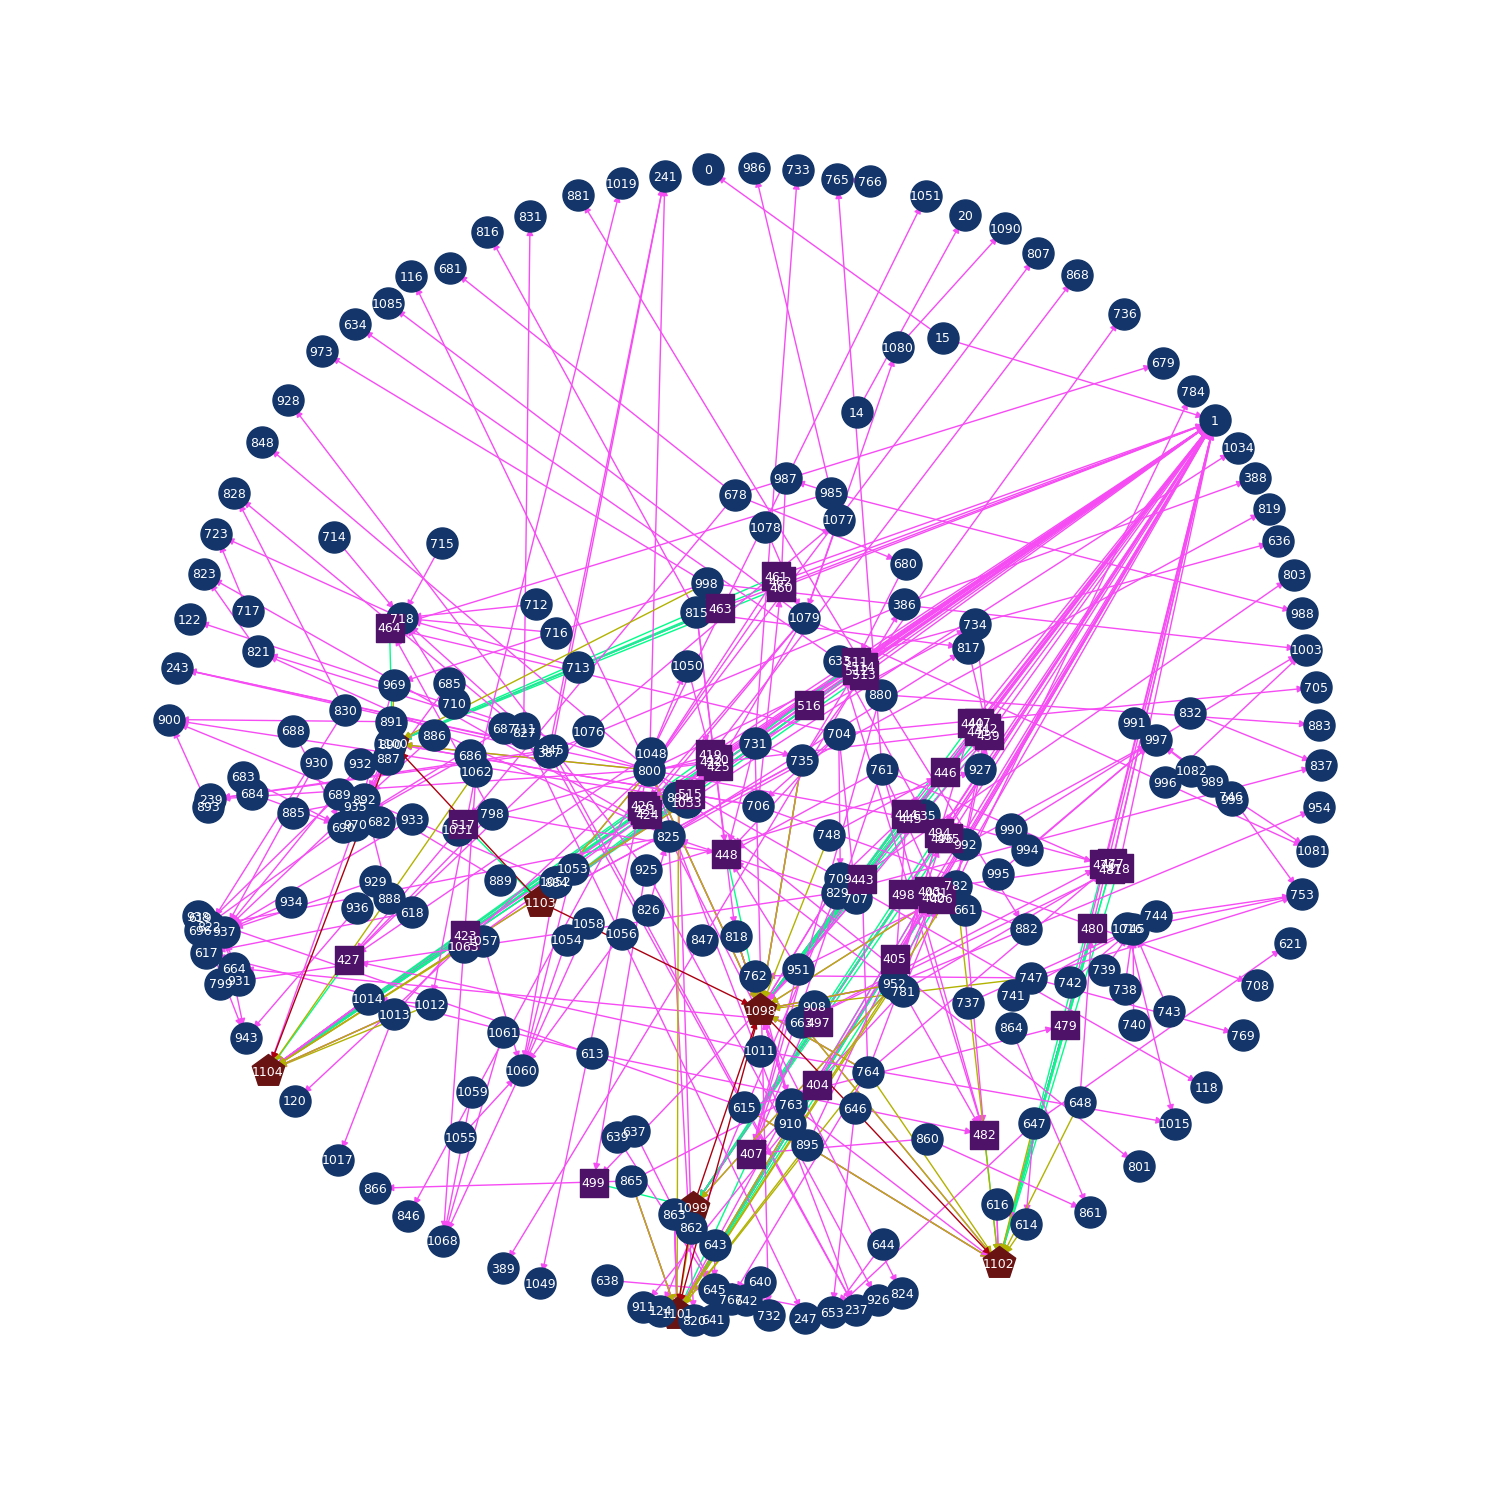

In [233]:
G = nx.MultiDiGraph()
new_ids = 0
blue = "#133569"
green = "#13692a"
red = "#691313"
purple = "#4e1369"
pink = "#F64CF4"
dark_red = "#ac0010"
cyan = "#2FEBF6"
mint = "#00ff88"
yellow = "#B2B200"
#add nodes
for e in entities:
    color = ""
    if e['entityId'] in persistent_set:
        color = green
    elif e['entityId'] in crud_dict.keys():
        color = purple
    else:
        color = blue
    for m in e['methods']:
        G.add_node(new_ids,identity=m['identity'],parameters=m['parameters'],returnType=m['returnType'],fields=m['fields'],color=color,node_shape="o")
        #print(e['entityId'],new_ids)
        new_ids = new_ids+1
#add call edges
identity_dict:dict = nx.get_node_attributes(G, "identity")
for e in entities:
    for m in e['methods']:
        _from = list(identity_dict.keys())[list(identity_dict.values()).index(m['identity'])]
        for c in m['invocations']:
            _to = list(identity_dict.keys())[list(identity_dict.values()).index(c)]
            G.add_edge(_from,_to,weight=0.8,name="CALL",color=pink)
#remove unused nodes
list_of_unconnected_nodes = [node for node in G.nodes if G.degree(node) == 0]
for n in list_of_unconnected_nodes:
    G.remove_node(n)
#add persistence entities
for e in persistent_set:
    color = red
    G.add_node(new_ids,name=entities_dict.get(e)['entityFullQualifiedName'],color=color,node_shape="p")
    new_ids = new_ids+1
#red to red references
name_dict:dict = nx.get_node_attributes(G, "name")
for r in relations:
    if not r['from'] == r['to'] and (r['from'] in persistent_set and r['to'] in persistent_set) and r['relationType'] == "FIELD":
        G.add_edge(list(name_dict.keys())[list(name_dict.values()).index(entities_dict.get(r['from'])['entityFullQualifiedName'])],
                   list(name_dict.keys())[list(name_dict.values()).index(entities_dict.get(r['to'])['entityFullQualifiedName'])],
                   weight=0.2,name='REFERENCES',color=dark_red)
for r in relations:
    if not r['from'] == r['to'] and (r['from'] in persistent_set and r['to'] in persistent_set) and r['relationType'] == "INHERITANCE":
        G.add_edge(list(name_dict.keys())[list(name_dict.values()).index(entities_dict.get(r['from'])['entityFullQualifiedName'])],
                   list(name_dict.keys())[list(name_dict.values()).index(entities_dict.get(r['to'])['entityFullQualifiedName'])],
                   weight=0.0,name='EXTENDS',color=cyan)
#merge green into red
for e in persistent_set:
    identity_dict:dict = nx.get_node_attributes(G, "identity")
    e = entities_dict.get(e)
    _graph_entity_id = list(name_dict.keys())[list(name_dict.values()).index(e['entityFullQualifiedName'])]
    for m in e['methods']:
        try:
            method_to_connect = list(identity_dict.keys())[list(identity_dict.values()).index(m['identity'])]
            G = nx.contracted_nodes(G,_graph_entity_id,method_to_connect)
        except ValueError:
            continue
#add edges purple to red
for e in crud_dict.keys():
    identity_dict:dict = nx.get_node_attributes(G, "identity")
    target_e = entities_dict.get(crud_dict.get(e))
    e = entities_dict.get(e)
    _graph_entity_id = list(name_dict.keys())[list(name_dict.values()).index(target_e['entityFullQualifiedName'])]
    for m in e['methods']:
        try:
            method_to_connect = list(identity_dict.keys())[list(identity_dict.values()).index(m['identity'])]
            G.add_edge(method_to_connect,_graph_entity_id,weight=1.0,name='PERSISTS',color=mint)
            G.nodes.get(method_to_connect)['node_shape'] = "s"
            #print(f"crud method from {e['entityFullQualifiedName']} connected to {target_e['entityFullQualifiedName']}")
        except ValueError:
            #print(f"crud method from {e['entityFullQualifiedName']} not found! (removed because of missing connection.)")
            continue
#add edges blue to red
for _red_node in G.nodes():
    if G.nodes.get(_red_node)['color'] == red:
        for _blue_node in G.nodes():
            if G.nodes.get(_blue_node)['color'] == blue:
                _all_field_types = ""
                _blue_node_field_list = G.nodes.get(_blue_node)['parameters']
                for _field_dict in _blue_node_field_list:
                    _all_field_types = _all_field_types + _field_dict['type']
                if G.nodes.get(_red_node)['name'] in G.nodes.get(_blue_node)['returnType']\
                        or G.nodes.get(_red_node)['name'] in G.nodes.get(_blue_node)['fields']\
                        or G.nodes.get(_red_node)['name'] in _all_field_types:
                    #print(G.nodes.get(_red_node)['name'],G.nodes.get(_blue_node)['identity'])
                    G.add_edge(_blue_node,_red_node,weight=0.6,name="USES",color=yellow)
print(G)
visualize_graph(G, fig_size=15, iterate=1000)

MultiDiGraph with 7 nodes and 7 edges


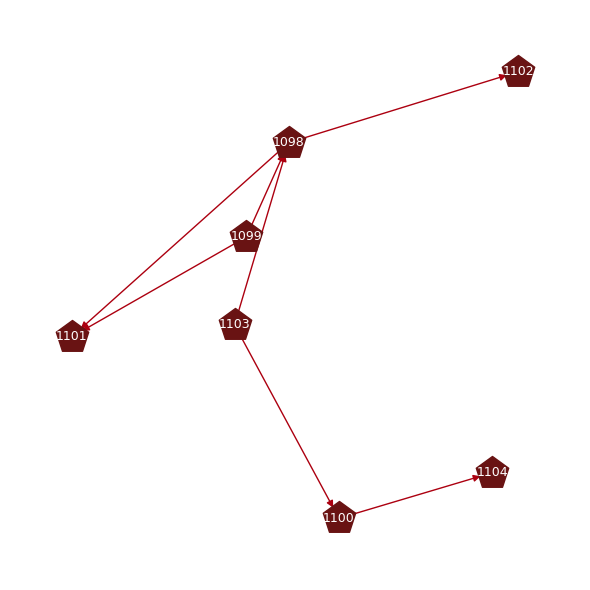

In [234]:
_entity_set = set()
for _red_node in G.nodes():
    if G.nodes.get(_red_node)['color'] == red:
        _entity_set.add(_red_node)
entity_graph = nx.subgraph(G, _entity_set)
print(entity_graph)
visualize_graph(entity_graph, fig_size=6, iterate=220)

In [235]:
entity_groupings = nx.community.louvain_communities(entity_graph, seed=42)
print(f"found {len(entity_groupings)} entity cluster with an average of: {round((len(entity_graph.nodes())/len(entity_groupings)),2)} nodes per cluster")

found 2 entity cluster with an average of: 3.5 nodes per cluster


In [236]:
from colorutils import Color
def get_random_color(brightness:float)->str:
    _c:Color = Color(hsv=(int(random.randint(0, 359)), 1.0, brightness))
    return _c.hex

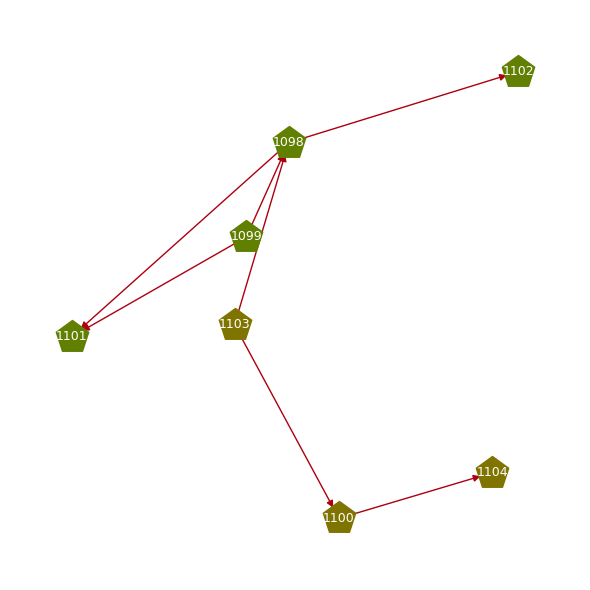

In [237]:
sub_entity_graph = entity_graph.copy()
for subset in entity_groupings:
    color = get_random_color(0.5)
    for _sub_node in subset:
        sub_entity_graph.nodes[_sub_node]['color'] = color
visualize_graph(sub_entity_graph, fig_size=6, iterate=220)

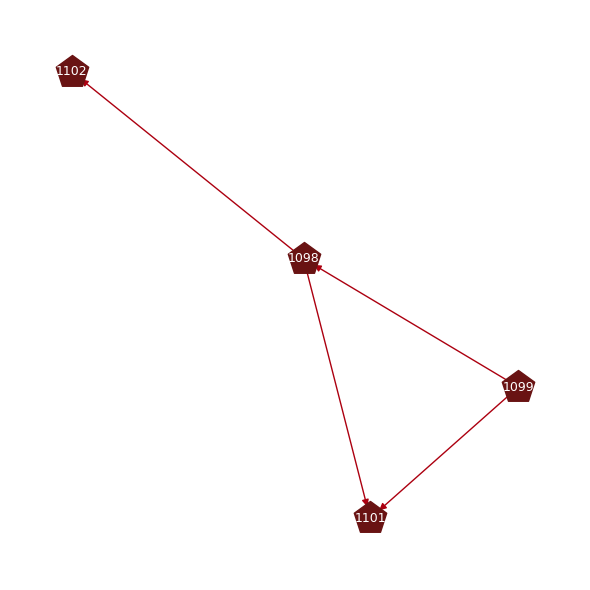

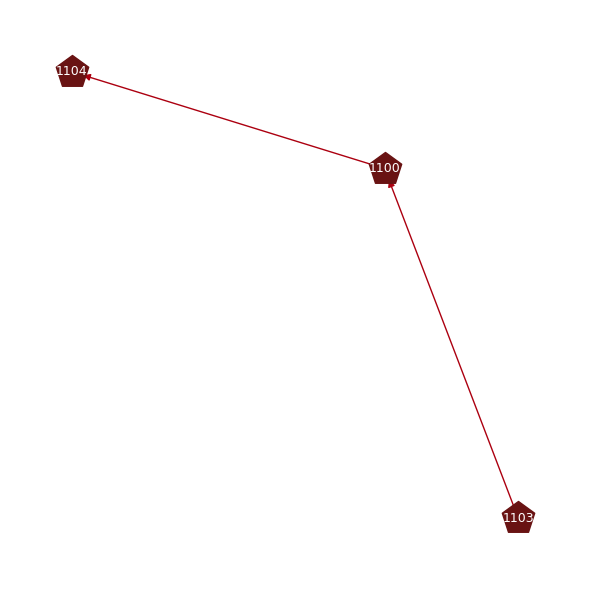

In [238]:
for subset in entity_groupings:
            _grouping_graph = nx.subgraph(entity_graph, subset)
            visualize_graph(_grouping_graph)

In [239]:
groupings = nx.community.louvain_communities(G, seed=42)

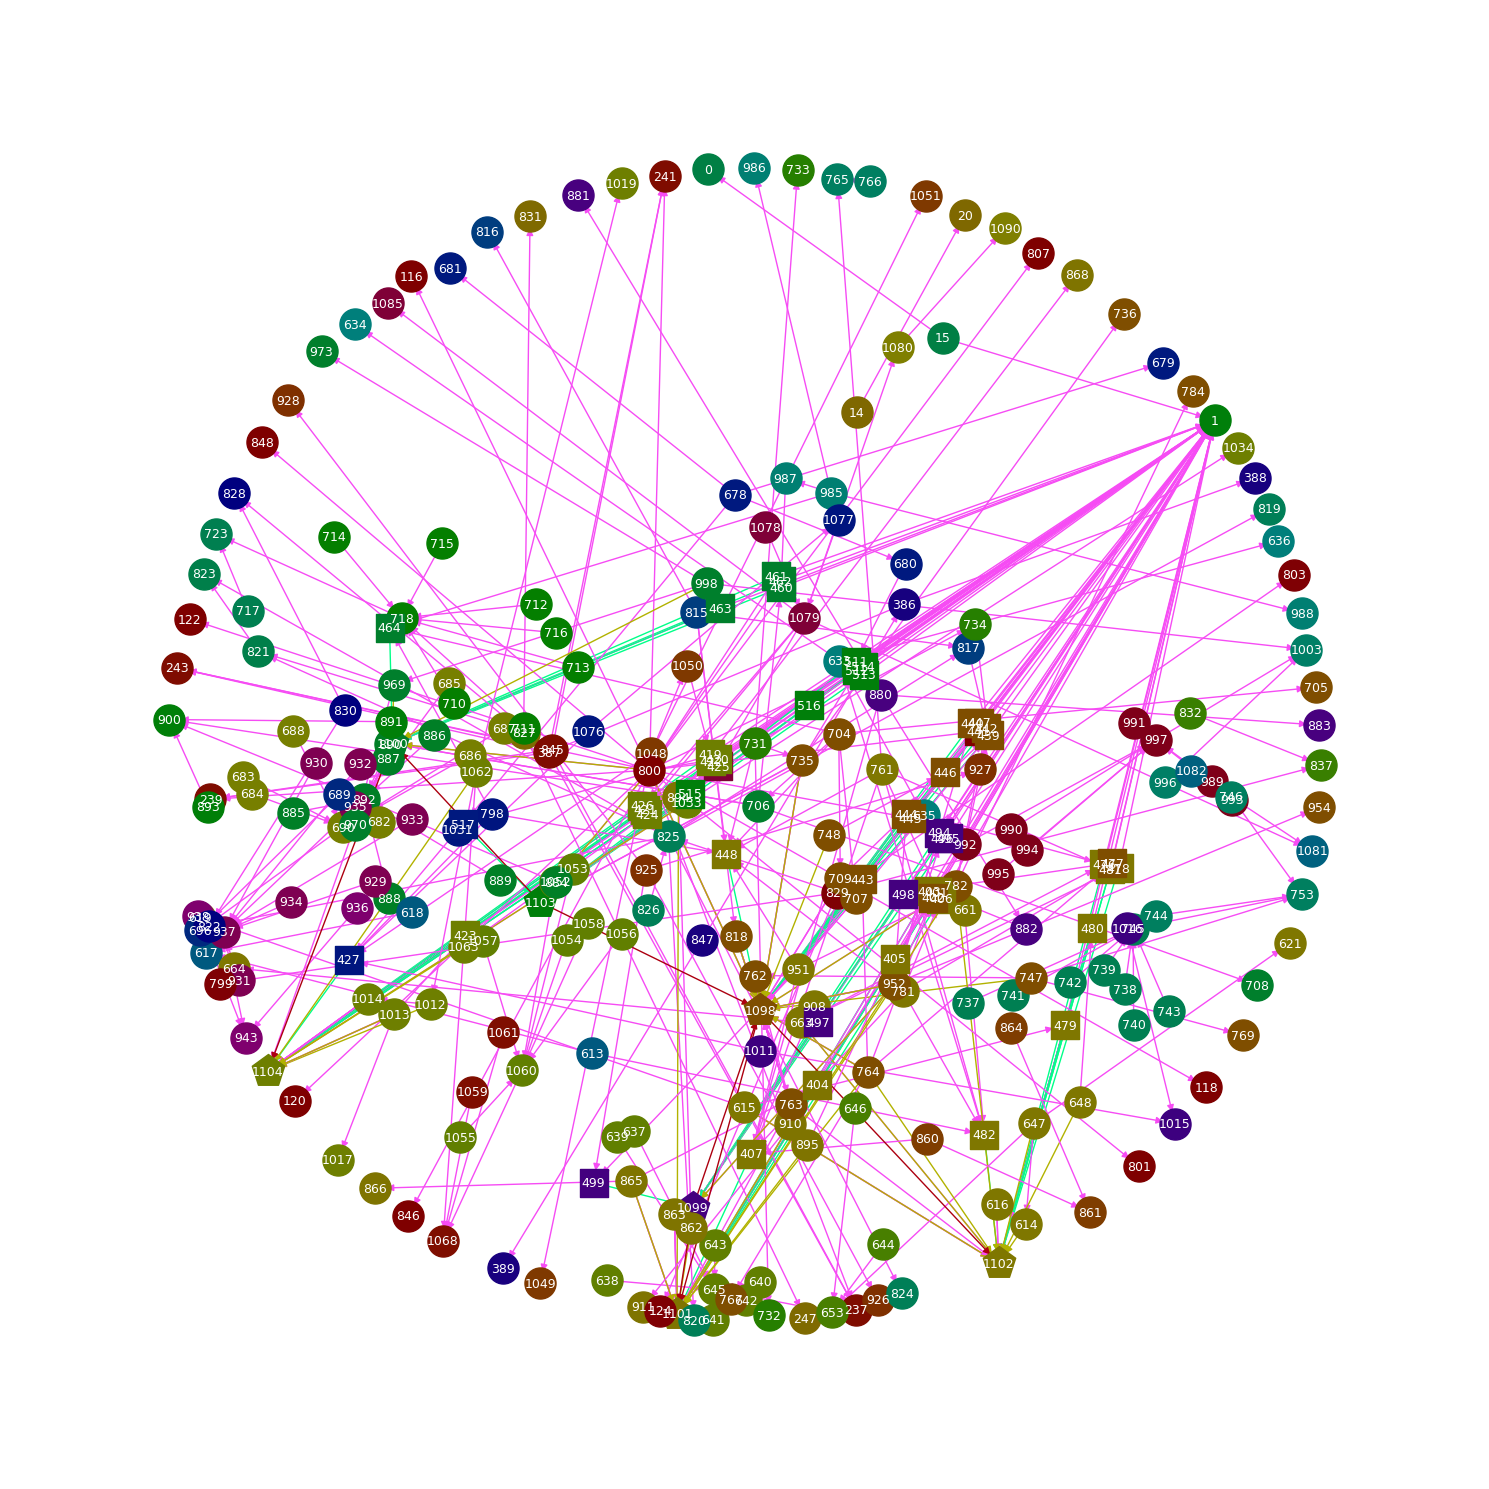

In [240]:
G2 = G.copy()
for subset in groupings:
    color = get_random_color(0.5)
    for _sub_node in subset:
        G2.nodes[_sub_node]['color'] = color
visualize_graph(G2, fig_size=15, iterate=1000)

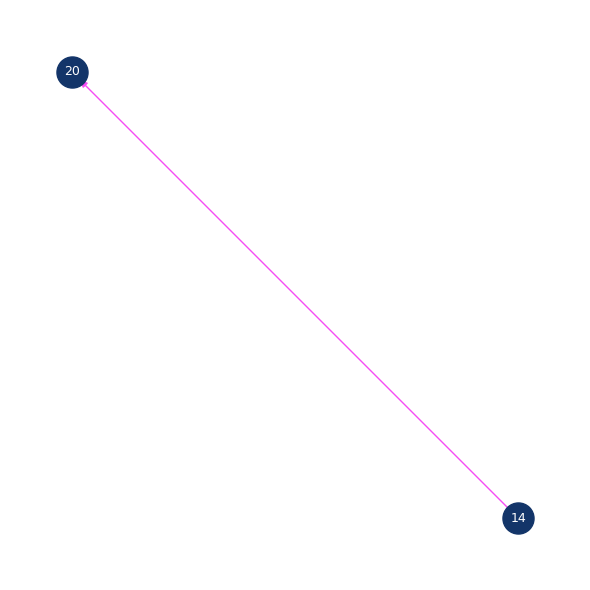

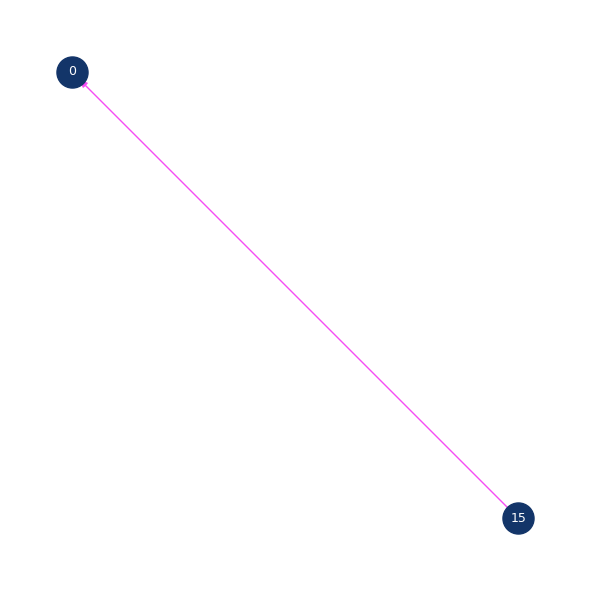

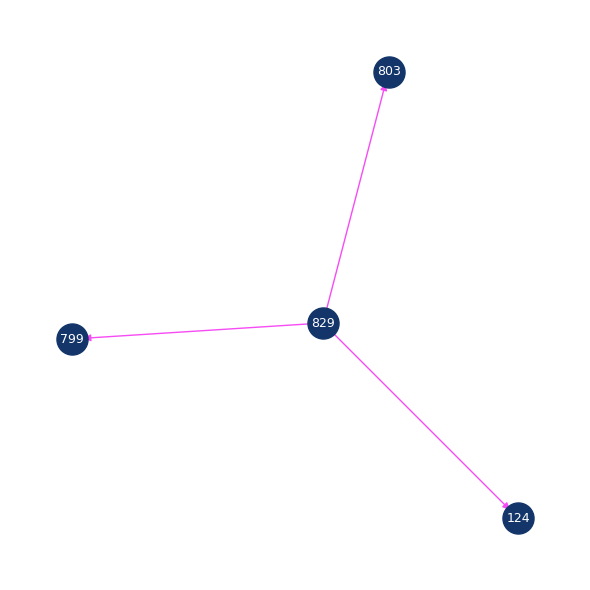

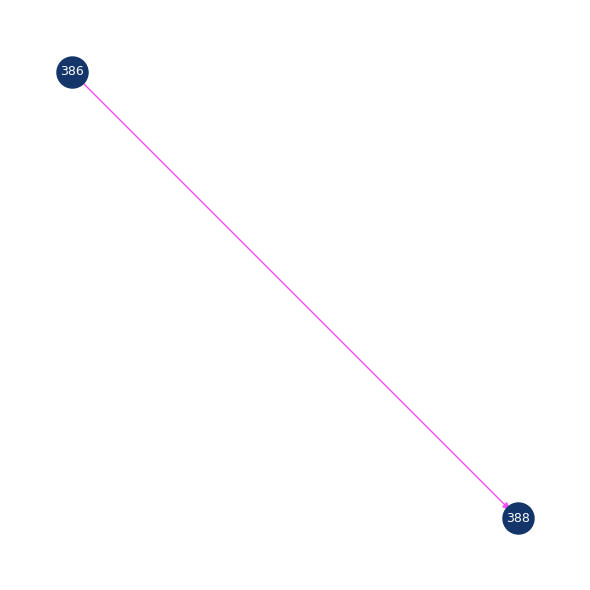

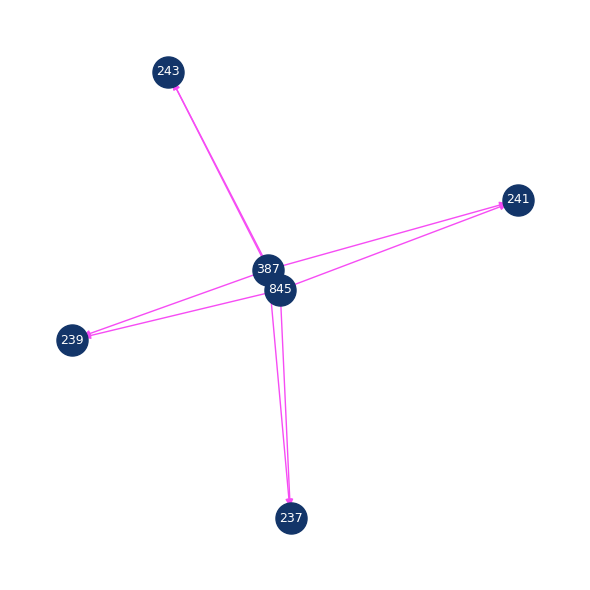

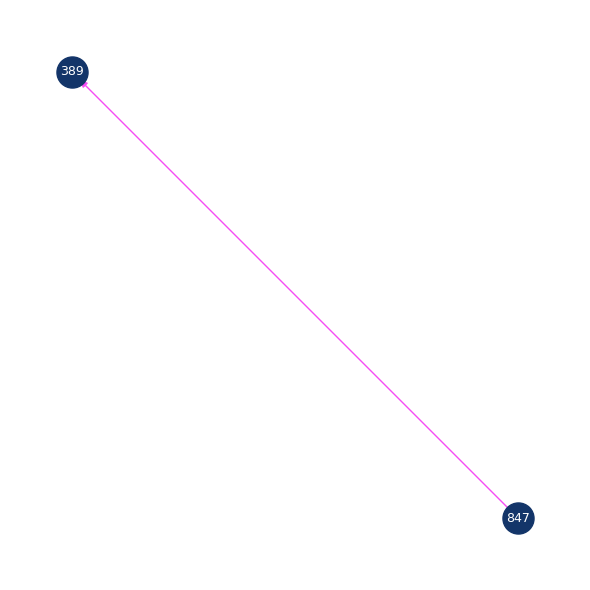

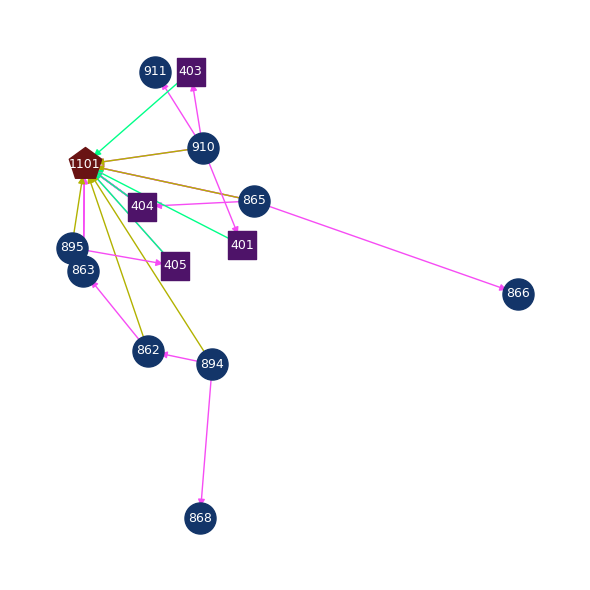

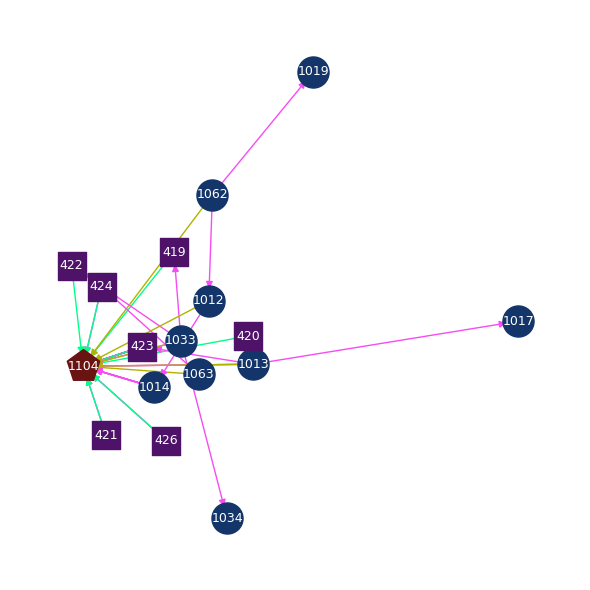

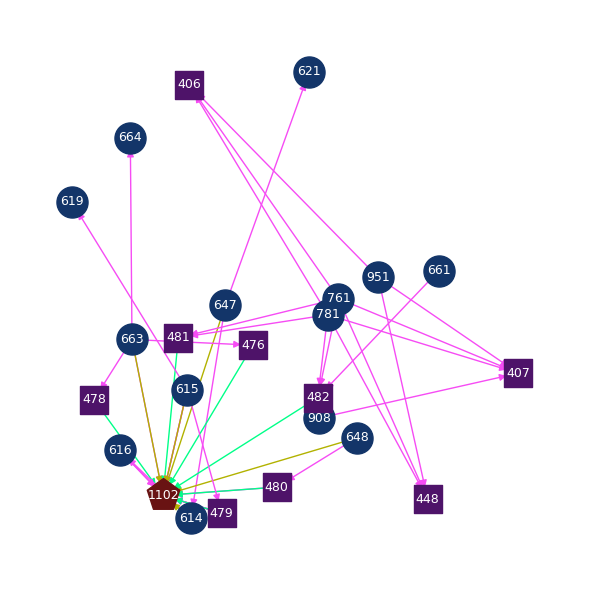

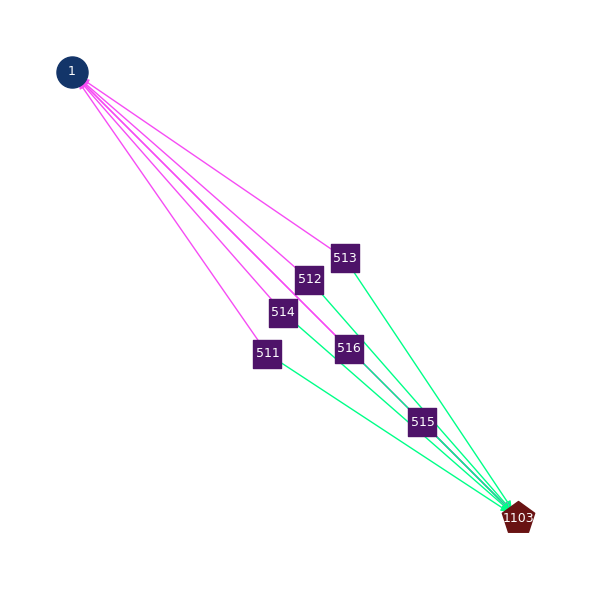

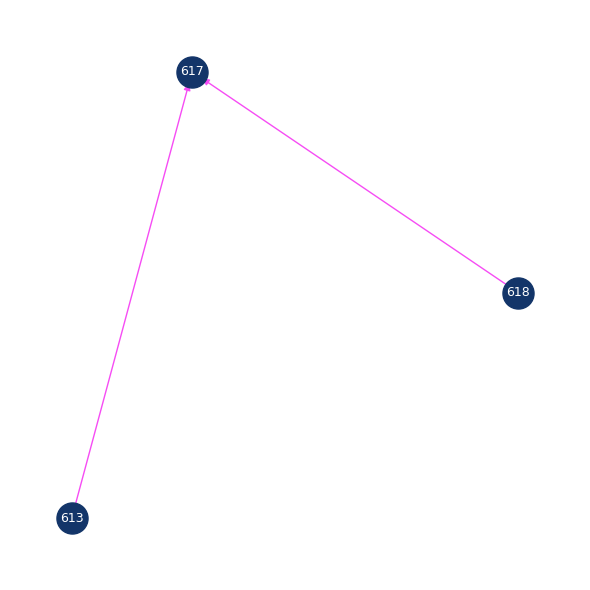

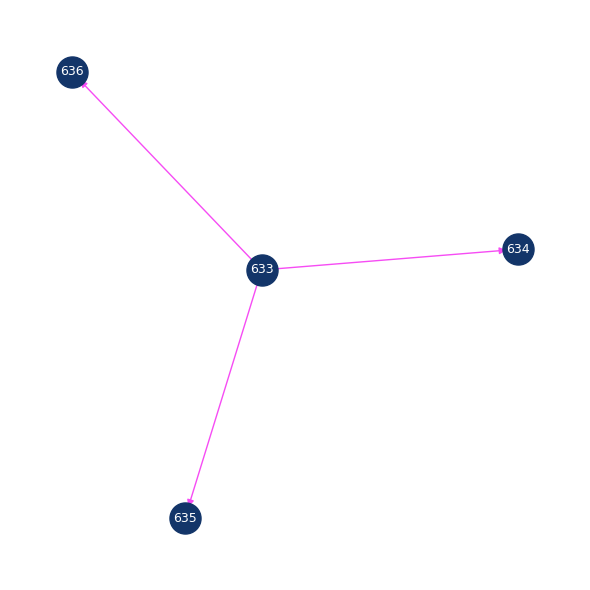

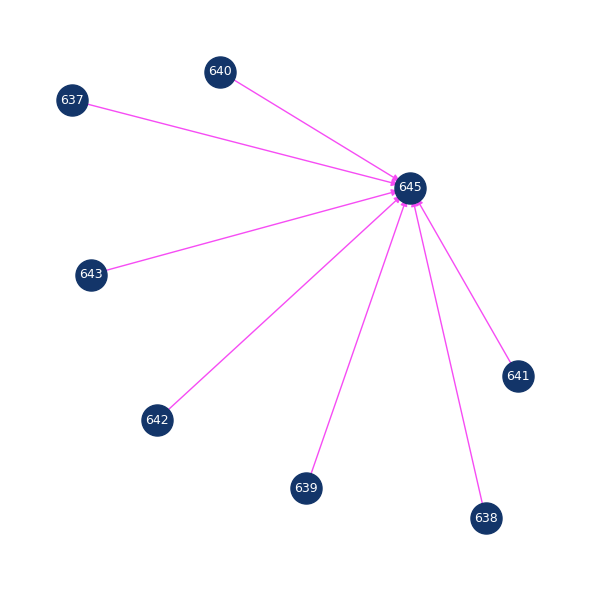

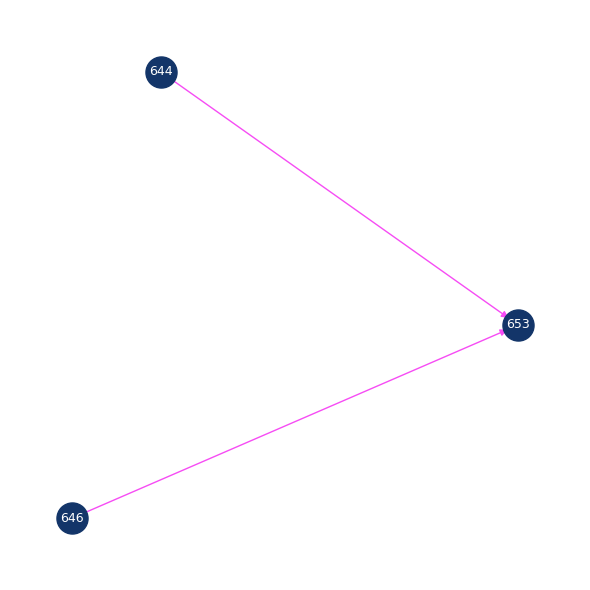

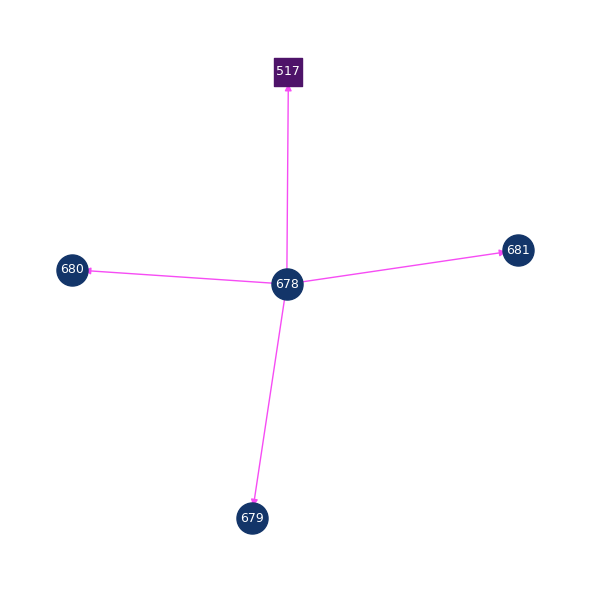

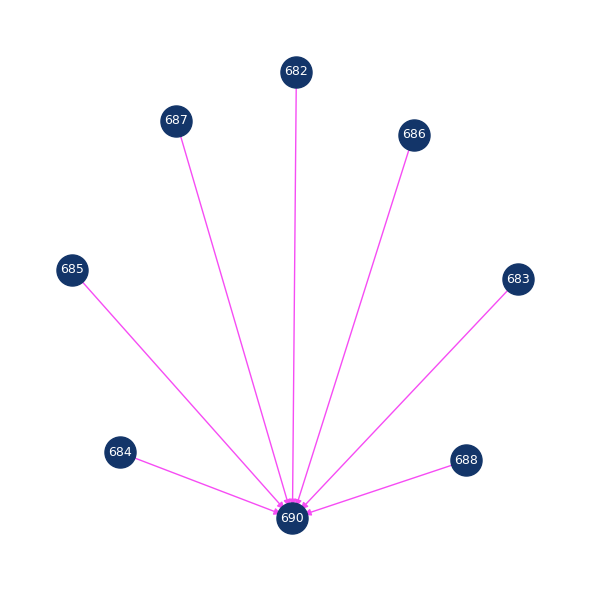

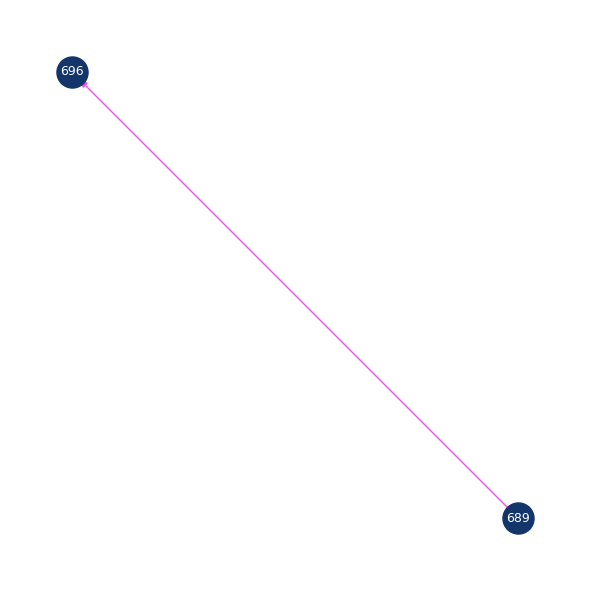

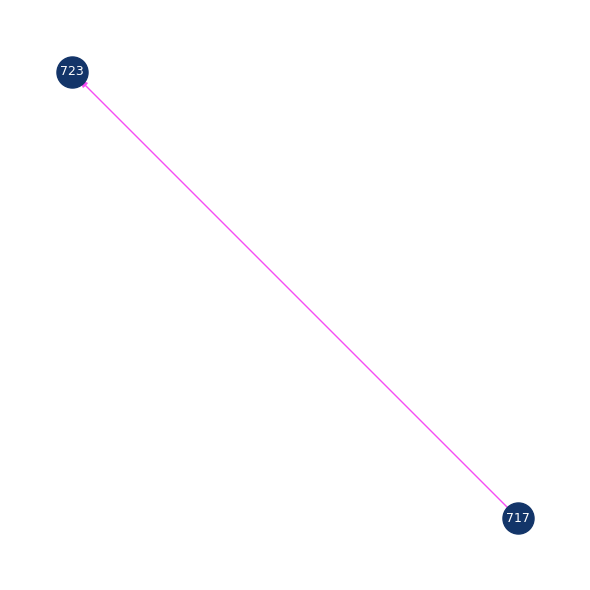

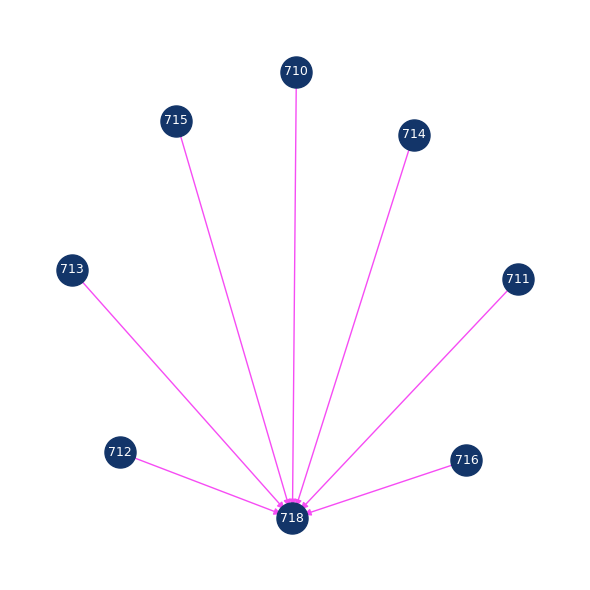

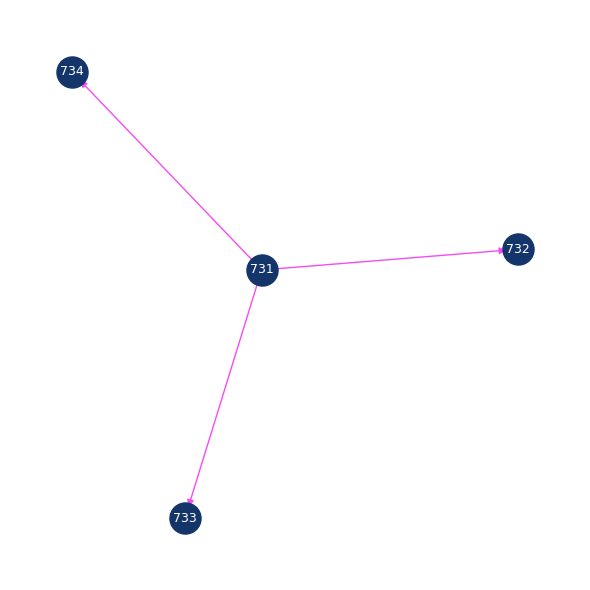

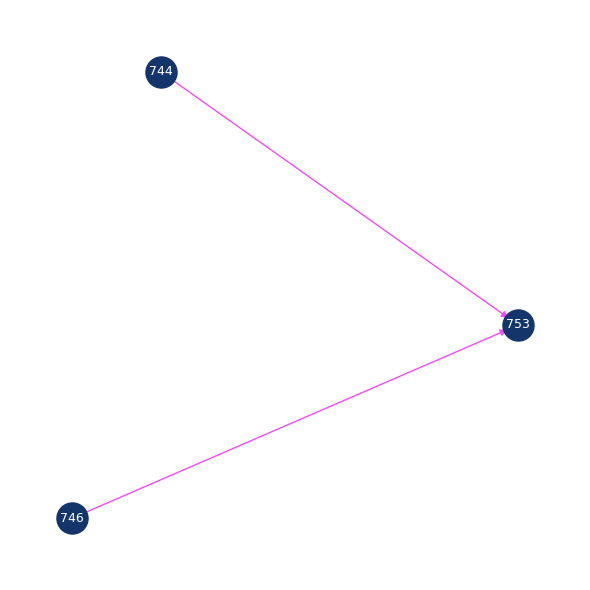

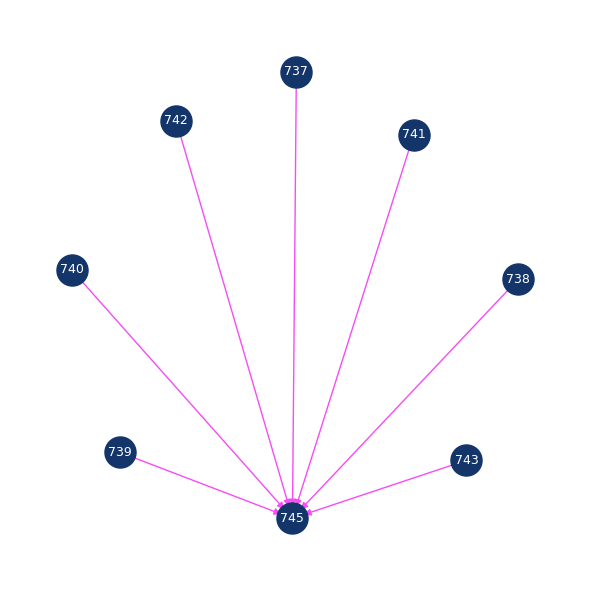

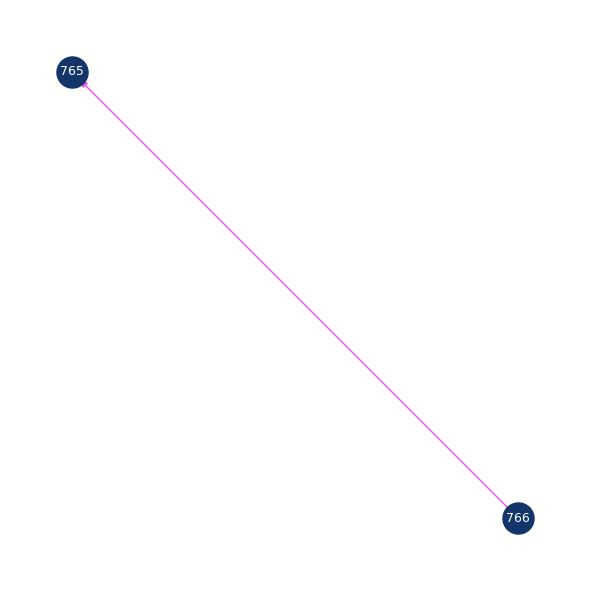

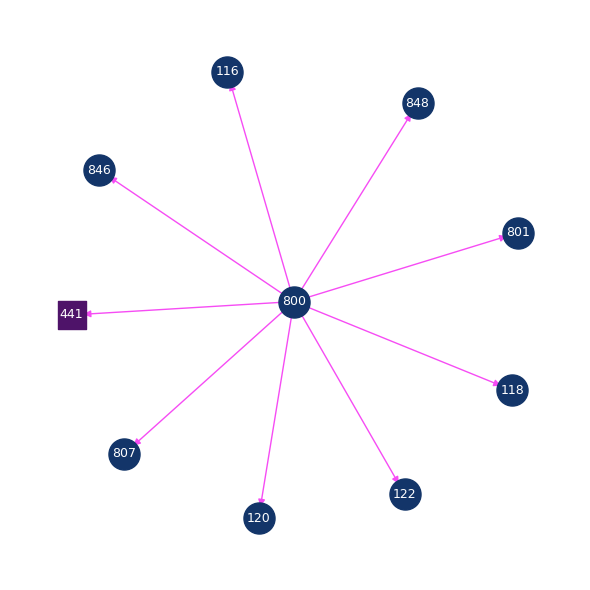

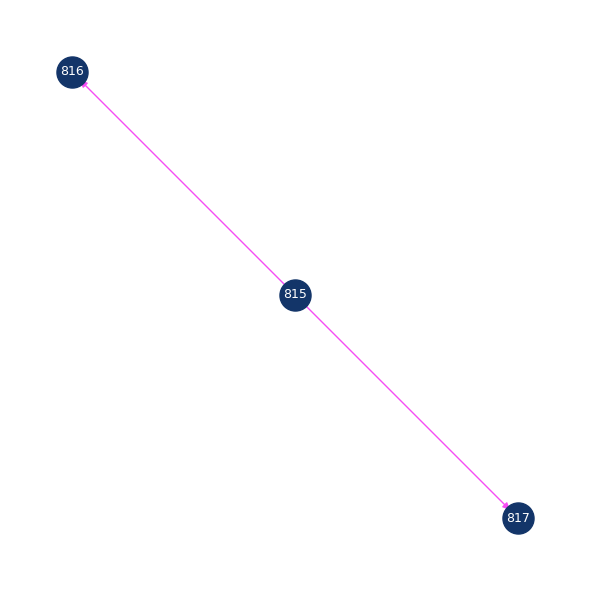

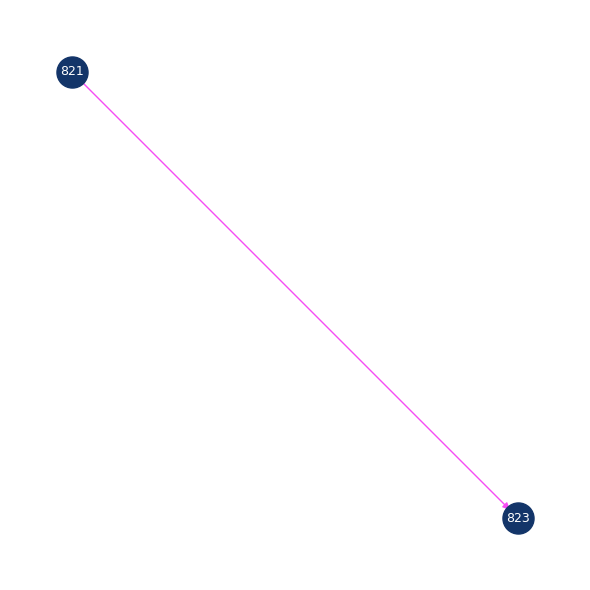

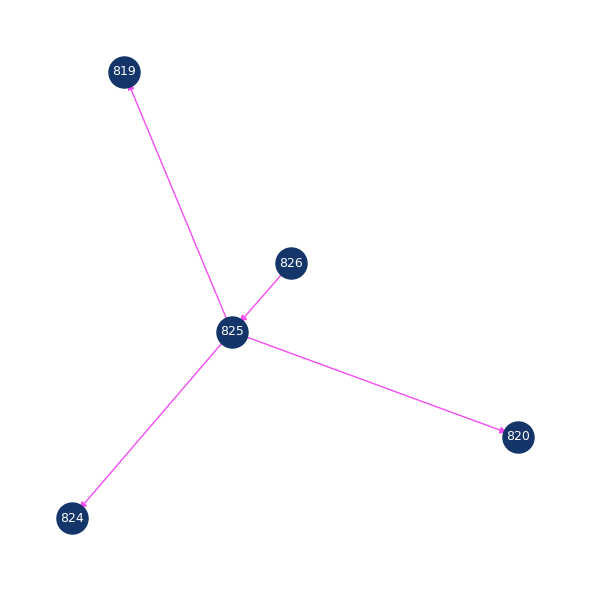

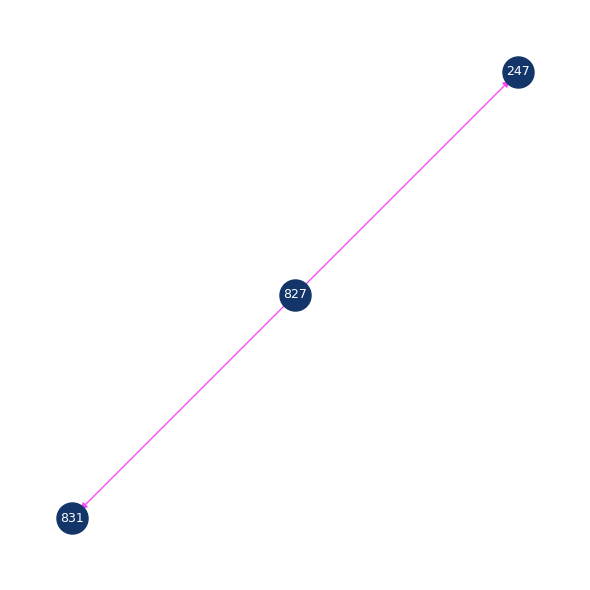

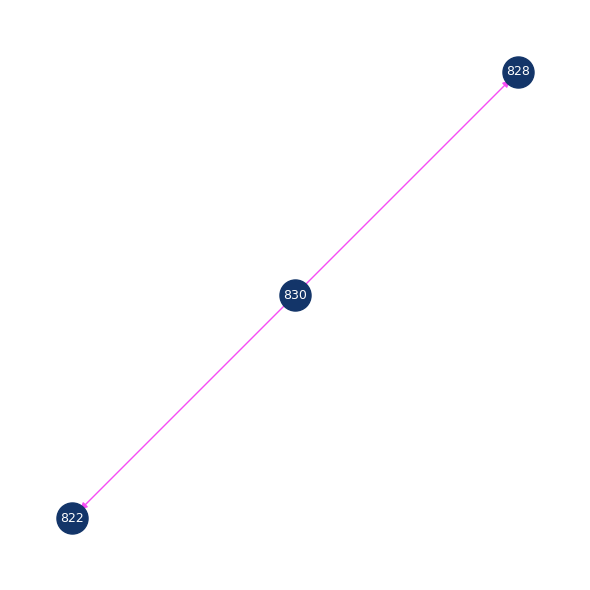

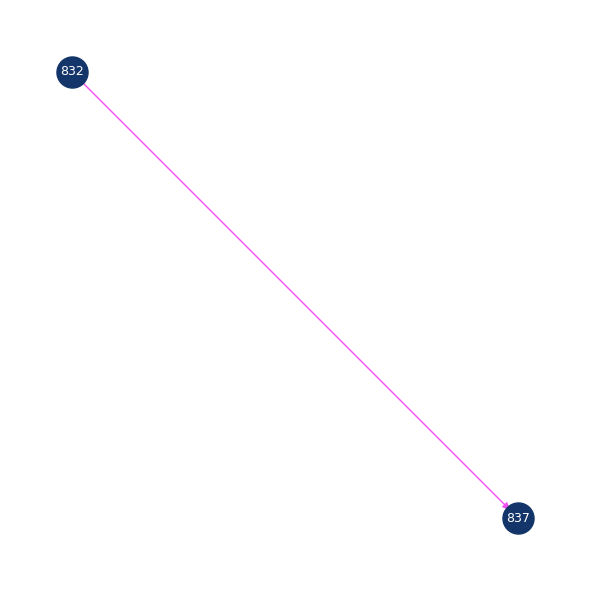

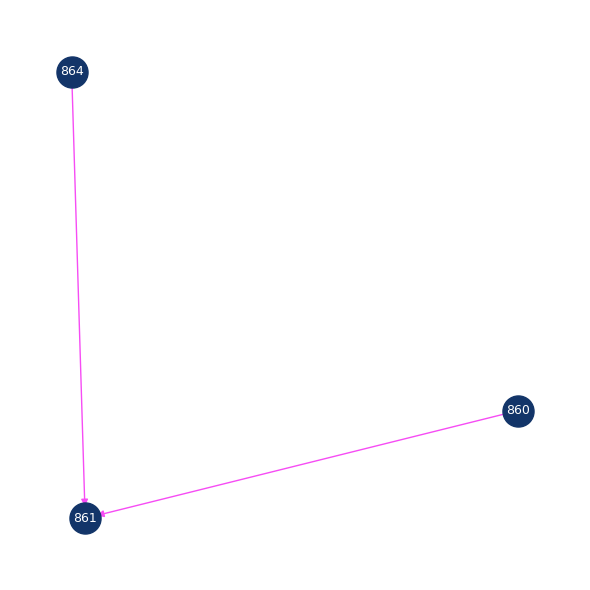

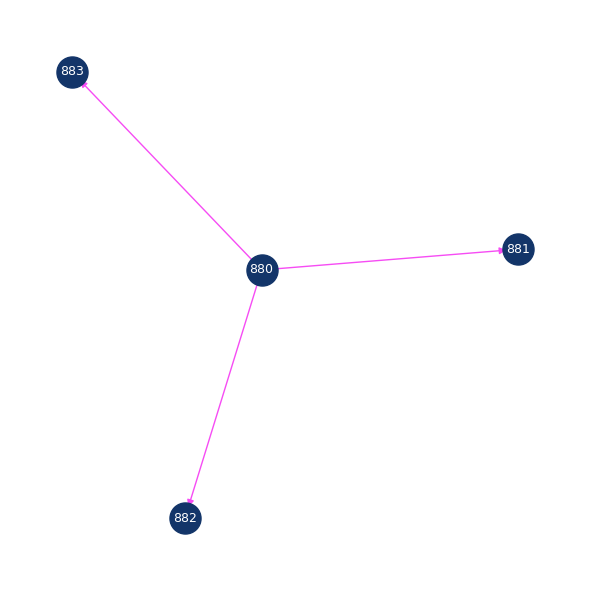

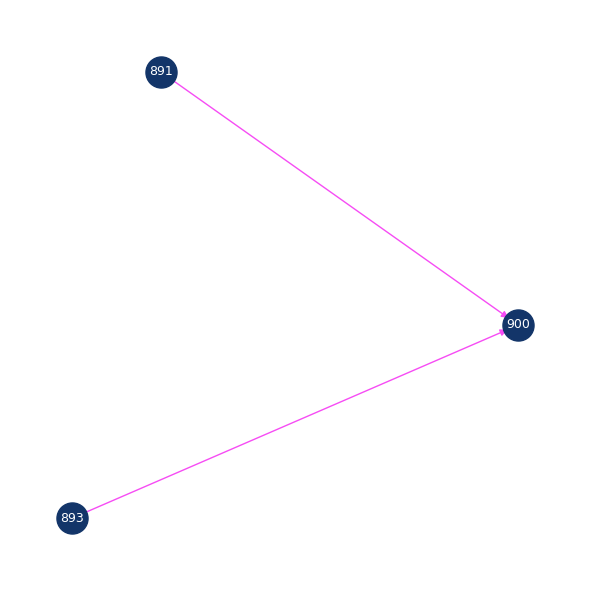

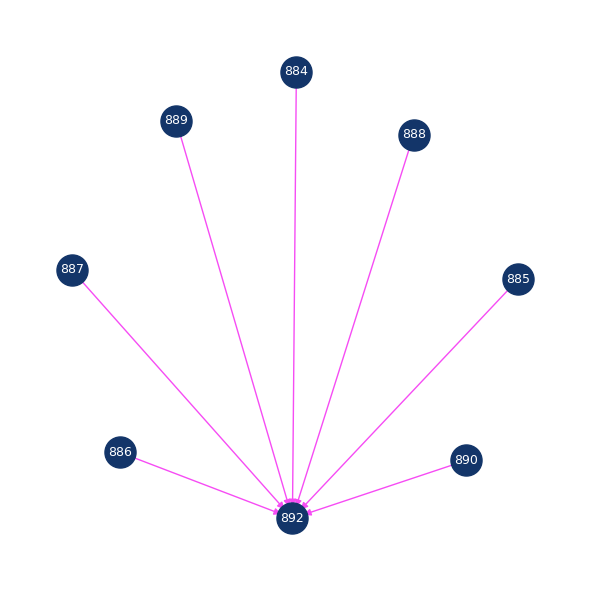

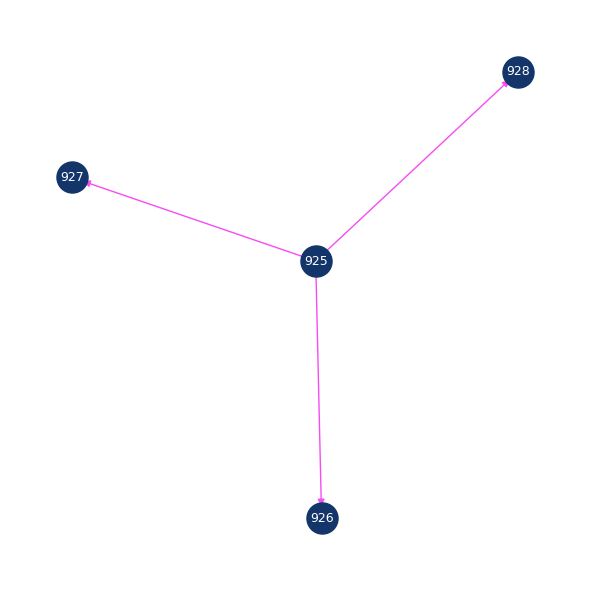

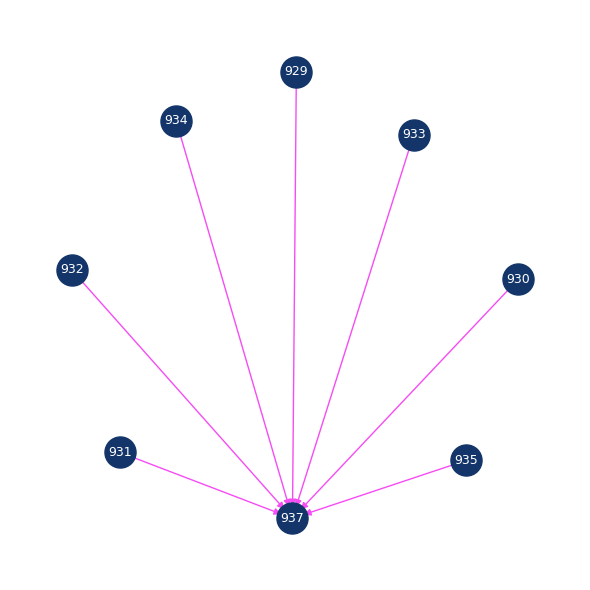

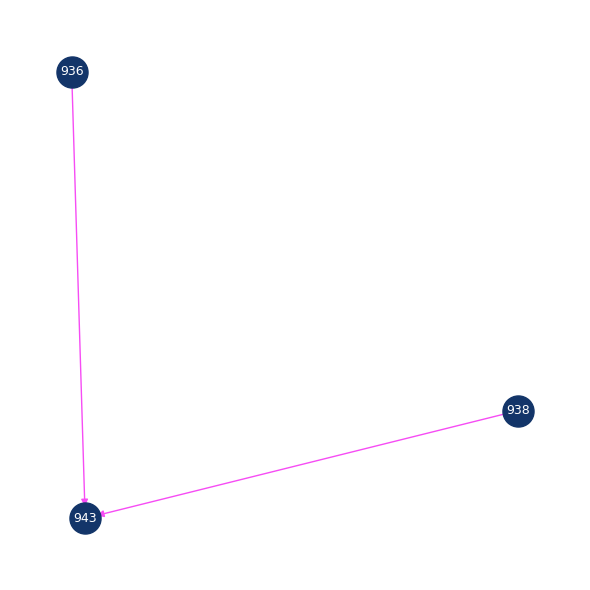

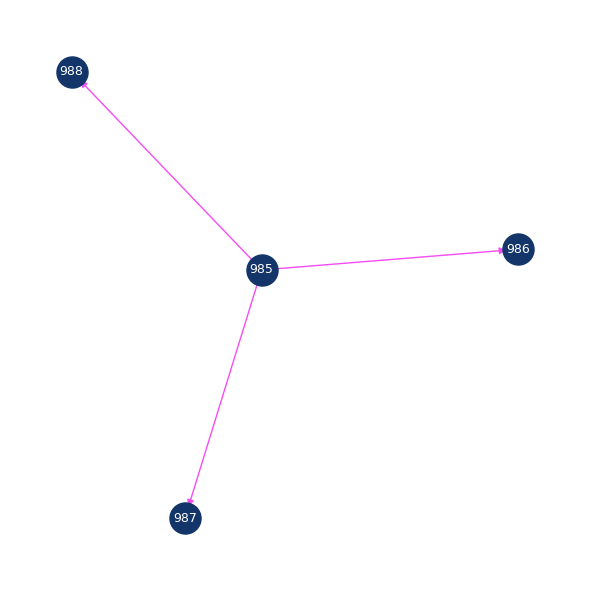

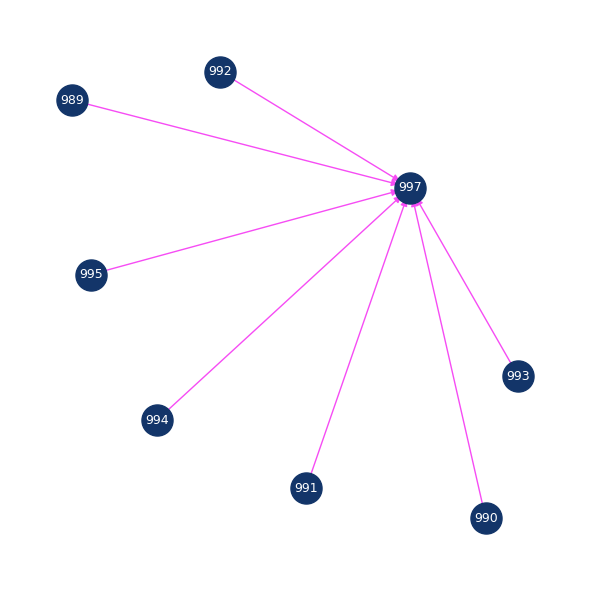

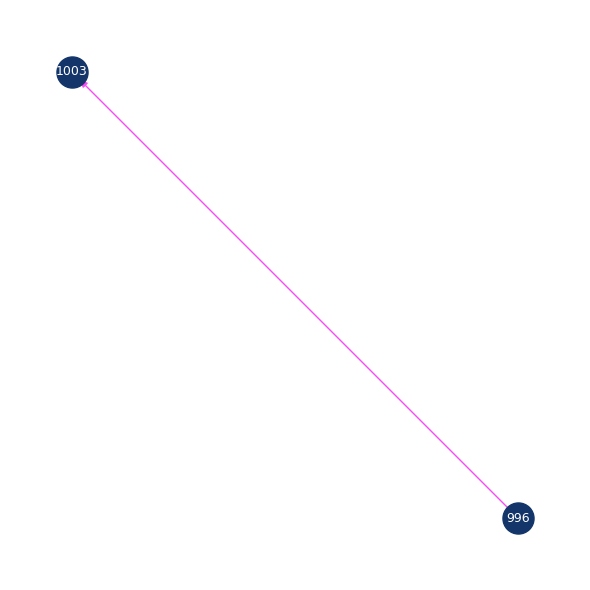

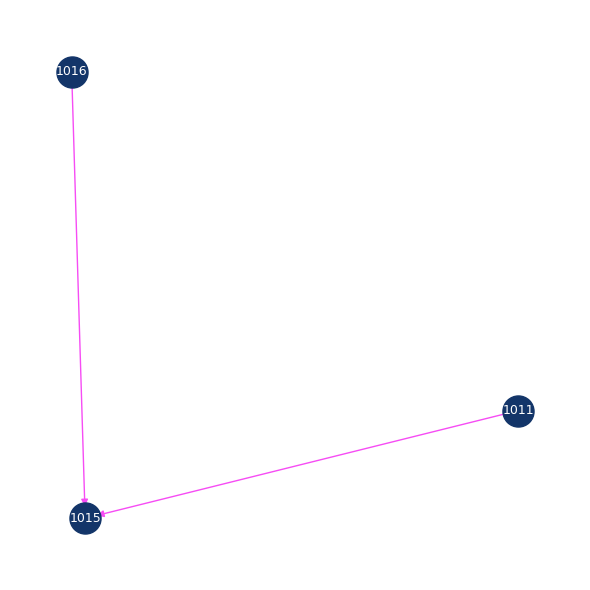

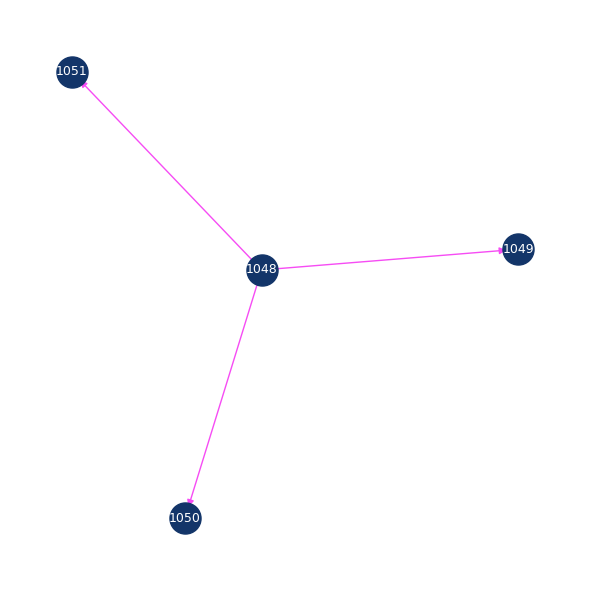

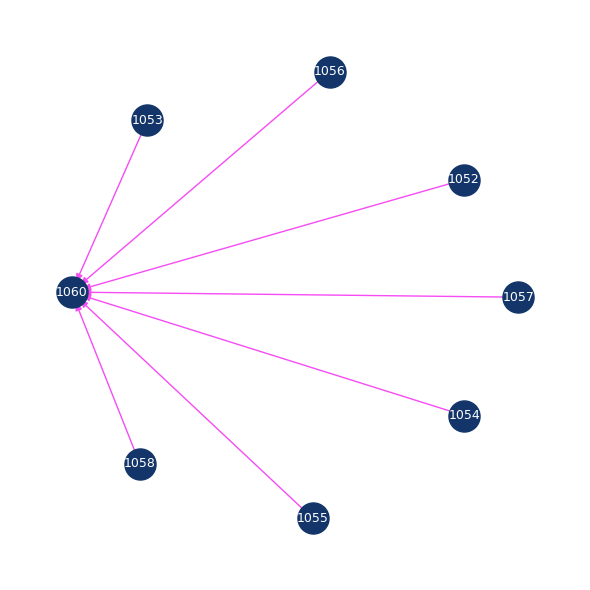

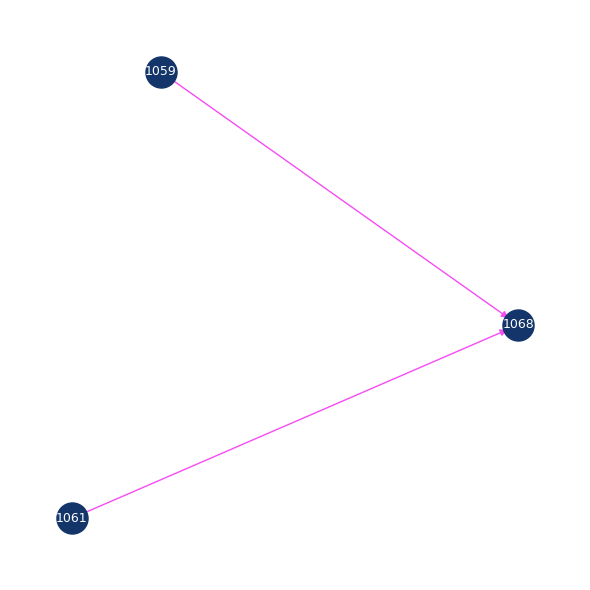

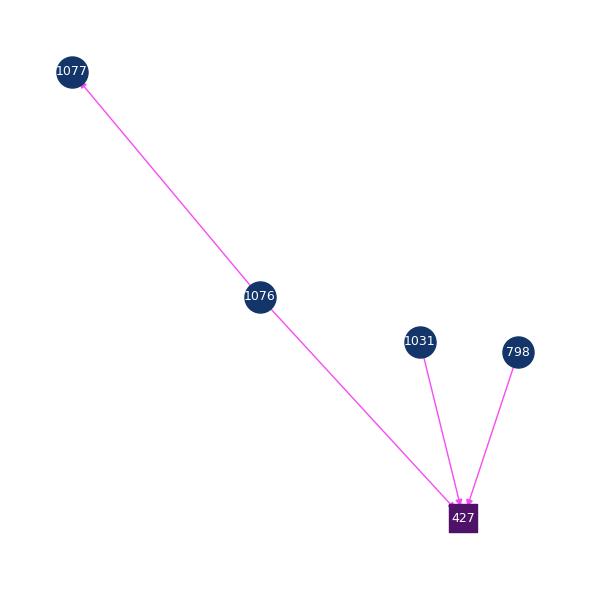

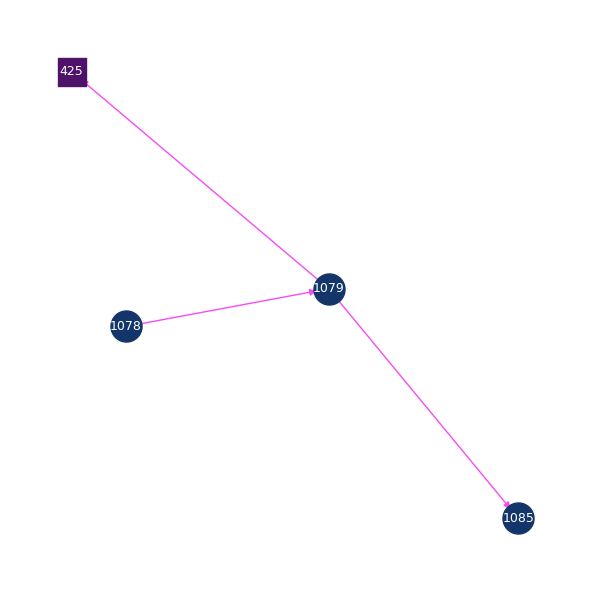

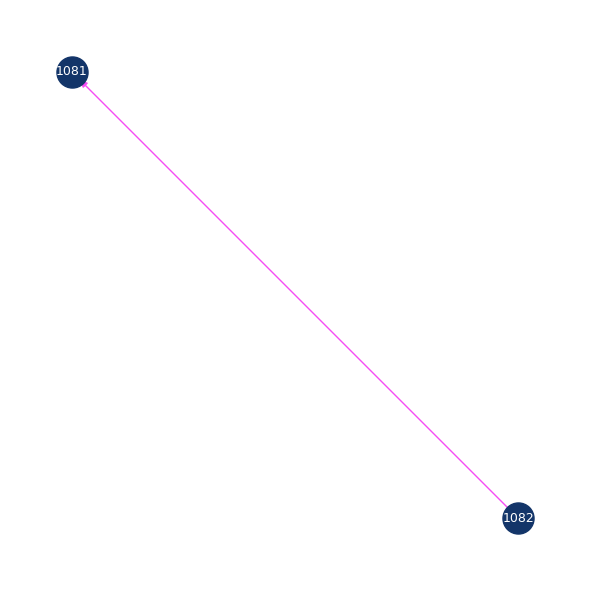

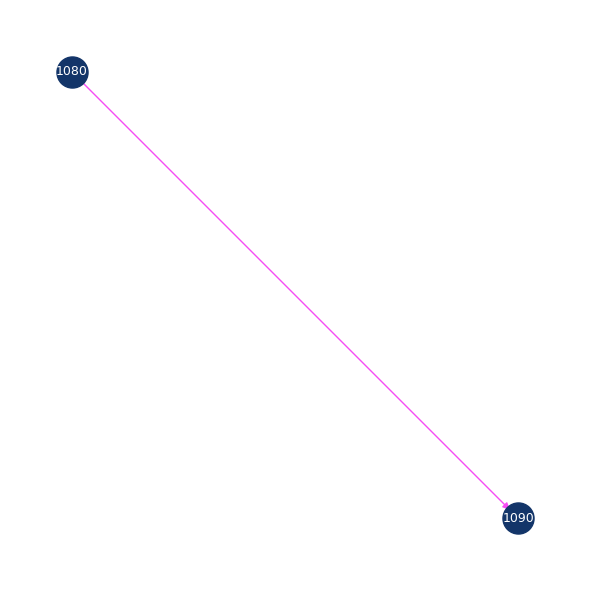

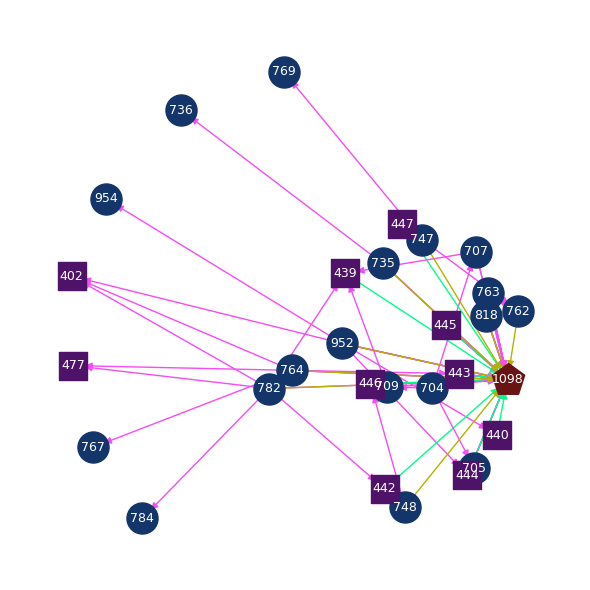

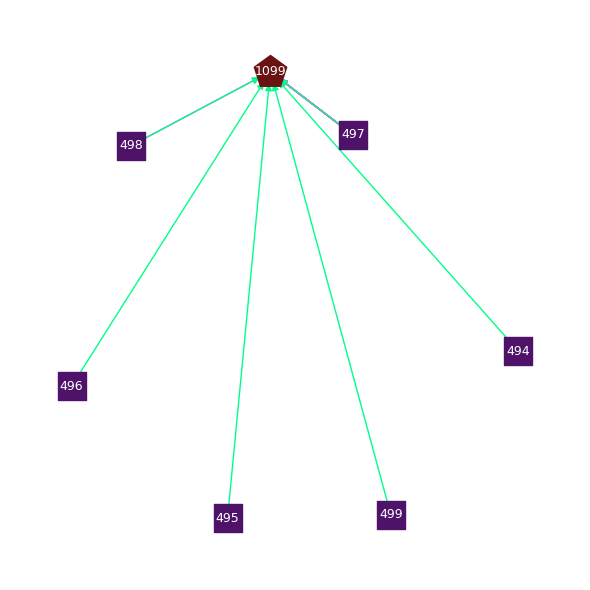

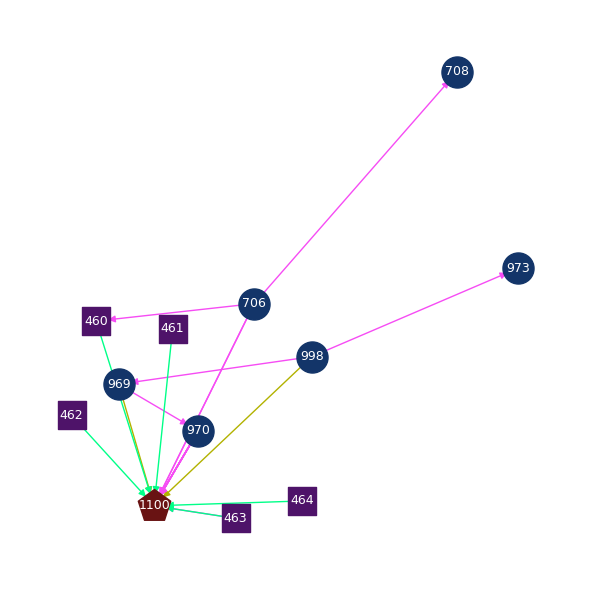

In [241]:
for subset in groupings:
            _grouping_graph = nx.subgraph(G, subset)
            visualize_graph(_grouping_graph)

In [242]:
cluster_map:dict = {}
for _e,_entity_cluster in enumerate(entity_groupings):
    cluster_map[_e]:list = list(_entity_cluster)
print(cluster_map)

{0: [1098, 1099, 1101, 1102], 1: [1104, 1100, 1103]}


In [0]:
from pulp import LpVariable, LpProblem, LpMinimize, LpStatus, value, lpSum

model = LpProblem("Minimal_MS_Architecture", LpMinimize)
x_values = {(i,k) for i in G.nodes() for k in range(len(entity_groupings))}
model.x = LpVariable.dicts("x",indices=x_values,cat='Binary')
z_values = {(i,j,k) for (i,j) in G.edges() for k in range(len(entity_groupings))}
model.z = LpVariable.dicts("z",indices=z_values,cat='Binary')
y_values = {(i,j) for (i,j) in G.edges()}
model.y = LpVariable.dicts("y",indices=y_values,cat="Binary")
for i in G.nodes():
    model += lpSum(model.x[i,k] == 1 for k in range(len(entity_groupings)))
for k in range(len(entity_groupings)):
    model += lpSum(model.x[i,k] for i in G.nodes() if G.nodes.get(i)['node_shape']!='p') >= 1
for (i,j) in G.edges():
    for k in range(len(entity_groupings)):
        model += model.z[i,j,k]-model.x[i,k] <= 0
        model += model.z[i,j,k]-model.x[j,k] <= 0
        model += model.x[i,k]+model.x[j,k]-model.z[i,j,k] <= 1
    model += model.y[i,j] == lpSum(model.z[i,j,k] for k in range(len(entity_groupings)))
for k,_entities in enumerate(cluster_map.values()):
    for i in _entities:
        model += model.x[i,k] == 1
for i,j in y_values:
    set_i:set = list(filter(lambda _sub: (i in _sub), groupings))[0]
    set_j:set = list(filter(lambda _sub: (j in _sub), groupings))[0]
    if len(set_i) != 0 and len(set_j) != 0 and groupings.index(set_i) == groupings.index(set_j):
        model += model.y[i,j] == 1

model += lpSum(G.edges.get(_tuple)['weight']*(1-model.y[_tuple[0],_tuple[1]]) for _tuple in G.edges)

status = model.solve()
print(LpStatus[status])

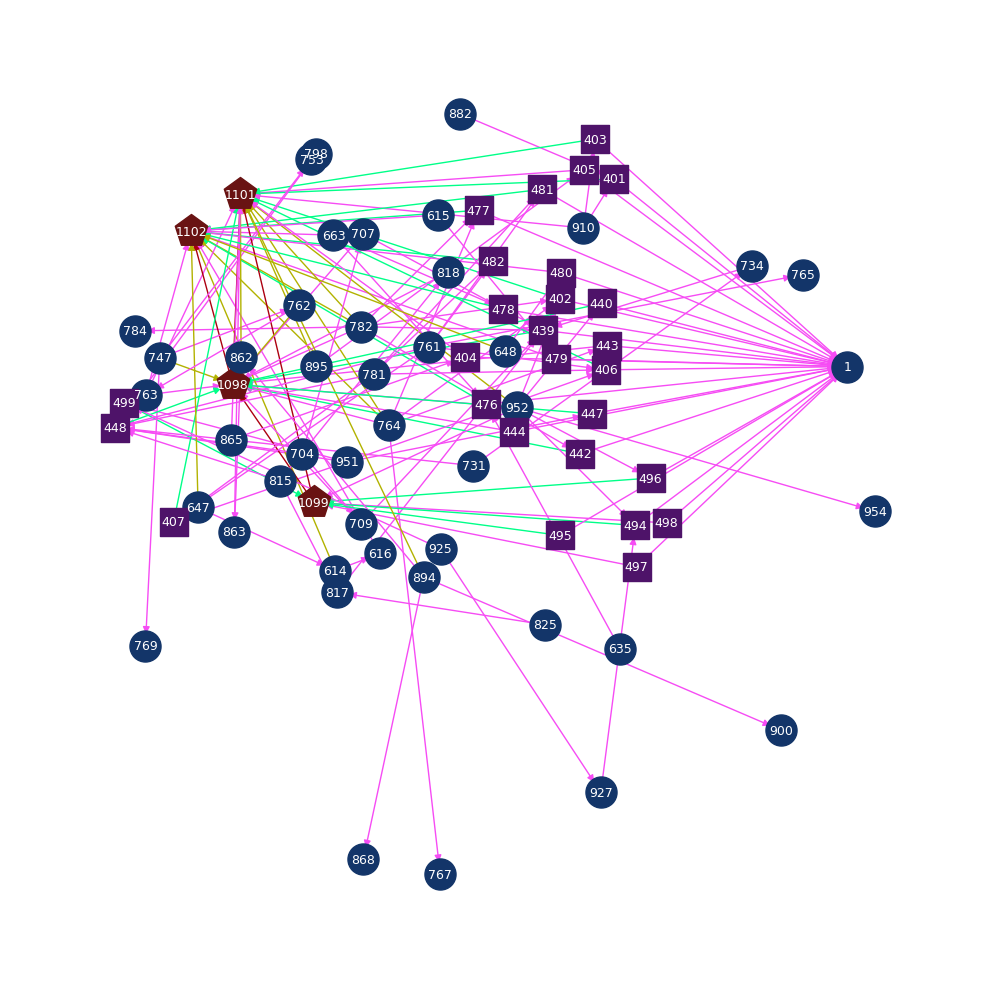

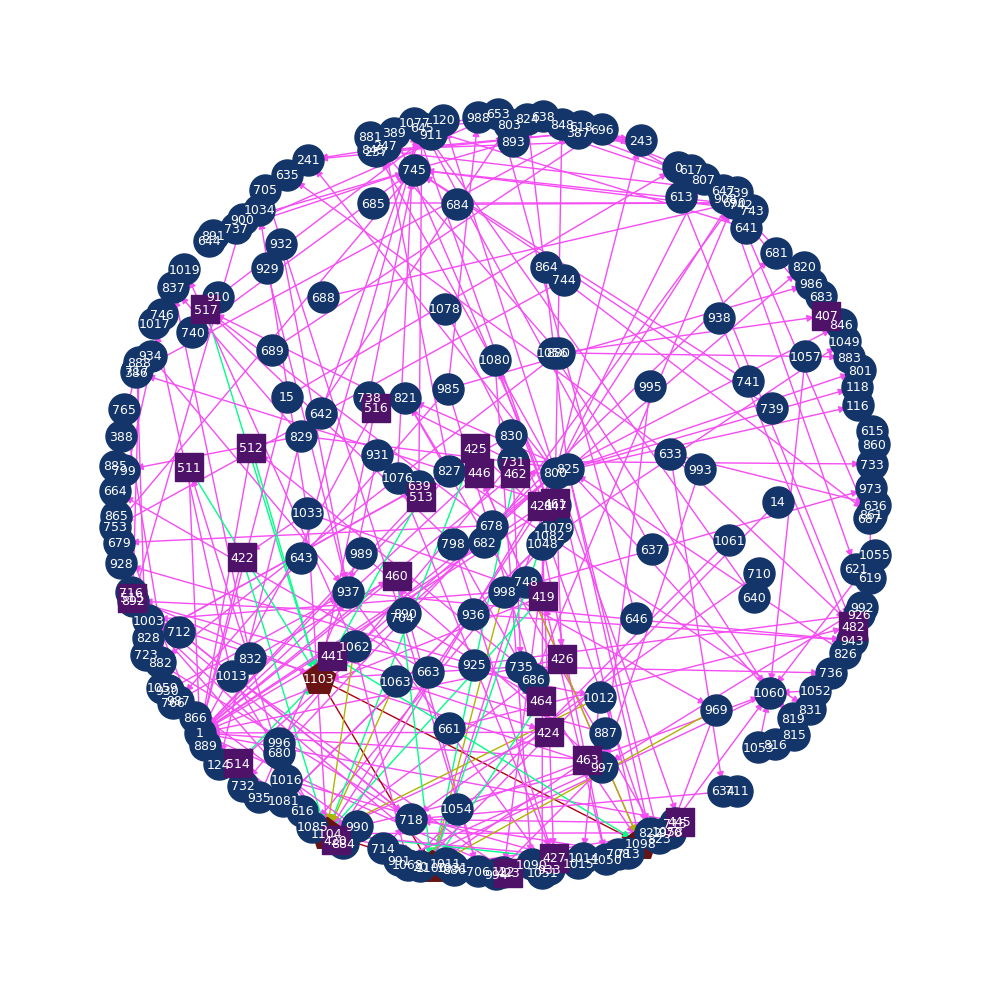

In [249]:
#build solution graphs
solution_graph_dict:dict = {}
for k in range(len(entity_groupings)):
    _solution_graph:nx.MultiDiGraph = nx.MultiDiGraph()
    solution_graph_dict[k] = _solution_graph
for (i,j,k) in z_values:
    if value(model.x[i,k]):
        solution_graph_dict.get(k).add_node(i,node_shape=G.nodes.get(i)['node_shape'],color=G.nodes.get(i)['color'])
    if value(model.z[i,j,k]):
        solution_graph_dict.get(k).add_node(j,node_shape=G.nodes.get(j)['node_shape'],color=G.nodes.get(j)['color'])
        solution_graph_dict.get(k).add_edge(i,j,color=(G.edges.get((i,j,0))['color']))
#visualize solution graphs
for k in range(len(entity_groupings)):
    visualize_graph(solution_graph_dict.get(k),10,250)

In [1]:
_duplicated_nodes:set = set()
for i in G.nodes():
    for k in range(len(entity_groupings)):
        if model.x[i,k] == 1.0 and model.x[i,1-k] == 1.0:
            _duplicated_nodes.add(i)
#visualize solution graphs combined
_colored_G2:nx.DiGraph = nx.DiGraph()
for k in range(len(entity_groupings)):
    color = get_random_color(0.5)
    for _node in solution_graph_dict.get(k).nodes():
        _colored_G2.add_node(f"{_node}_{k}",color=color,node_shape=G.nodes.get(_node)['node_shape'])
    for (i,j) in solution_graph_dict.get(k).edges():
        _colored_G2.add_edge(f"{i}_{k}",f"{j}_{k}",color=color,weight=100)
for (i,j) in y_values:
    if value(model.y[i,j] == 0.0):
        for k in range(len(entity_groupings)):
            if value(model.x[i,k]) and value(model.x[j,1-k]) and i not in _duplicated_nodes and j not in _duplicated_nodes:
                _colored_G2.add_edge(f"{i}_{k}",f"{j}_{1-k}",color="#000000",weight=0.00001)
visualize_graph(_colored_G2,30,400)
# Compute cohesion:
inside_w = dict()
outside_w = dict()

for i,j in G.edges():
    for k in range(len(entity_groupings)):
        if model.z[i,j,k] == 1: # Edge (i,j) is inside microservice k: sum the weight as inside
            inside_w[k] = inside_w.get(k, 0) + G[i][j]['weight']
        if model.x[i,k] == 1: # Edge (i,j) has its origin in k: sum the weigh as outside
            outside_w[k] = outside_w.get(k, 0) + G[i][j]['weight']

cohesion_dict = dict()
for k in  range(len(entity_groupings)):
    cohesion_dict[k] = inside_w[k] / outside_w[k]

cohesion = sum(cohesion_dict.values())/len(entity_groupings)

NameError: name 'G' is not defined